## Analisis Index Kemiskinan Nasional dengan Metode Linear Regression PySpark
#### Febro Herdyanto - 312010043

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import HTML
import webbrowser

In [2]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName("LinearRegressionAnalysis").getOrCreate()

In [3]:
# Load Dataset
file_path = "Dataset/index_kemiskinan_nasional.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
# Tampilkan schema dataset
df.printSchema()

root
 |-- nama_variabel: string (nullable = true)
 |-- nama_tahun: integer (nullable = true)
 |-- nama_wilayah: string (nullable = true)
 |-- data_content: string (nullable = true)



In [5]:
# Filter hanya untuk "Index Kedalaman Kemiskinan" dan "Index Keparahan Kemiskinan"
filtered_df = df.filter((col("nama_variabel") == "Index Kedalaman Kemiskinan") | (col("nama_variabel") == "Index Keparahan Kemiskinan"))

# Tampilkan 20 data pertama
filtered_df.show(20)

+--------------------+----------+---------------+------------+
|       nama_variabel|nama_tahun|   nama_wilayah|data_content|
+--------------------+----------+---------------+------------+
|Index Kedalaman K...|      2023|           ACEH|        2.76|
|Index Kedalaman K...|      2023|       Simeulue|        3.26|
|Index Kedalaman K...|      2023|   Aceh Singkil|        2.99|
|Index Kedalaman K...|      2023|   Aceh Selatan|        1.85|
|Index Kedalaman K...|      2023|  Aceh Tenggara|        1.59|
|Index Kedalaman K...|      2023|     Aceh Timur|        2.43|
|Index Kedalaman K...|      2023|    Aceh Tengah|        2.21|
|Index Kedalaman K...|      2023|     Aceh Barat|        2.47|
|Index Kedalaman K...|      2023|     Aceh Besar|           2|
|Index Kedalaman K...|      2023|          Pidie|        4.09|
|Index Kedalaman K...|      2023|        Bireuen|         1.9|
|Index Kedalaman K...|      2023|     Aceh Utara|        2.16|
|Index Kedalaman K...|      2023|Aceh Barat Daya|      

In [6]:
# Tampilkan jumlah null/NaN pada kolom data_content
null_count = df.filter(col("data_content").isNull() | isnan("data_content")).count()
print(f"Jumlah Null/NaN pada data_content: {null_count}")

Jumlah Null/NaN pada data_content: 0


In [7]:
# Tangani null/NaN pada kolom data_content dengan menghapus baris yang mengandung null/NaN
df = df.na.drop(subset=["data_content"])

In [8]:
# Ubah tipe data kolom data_content, nama_tahun, dan variabel lainnya menjadi float
columns_to_cast = ["data_content", "nama_tahun"]
for col_name in columns_to_cast:
    df = df.withColumn(col_name, df[col_name].cast("float"))

In [9]:
# Pastikan tidak ada nilai null pada kolom target (data_content)
df = df.filter(col("data_content").isNotNull())

In [10]:
# Filter data untuk wilayah tertentu
wilayah = "JAWA BARAT"
df_wilayah = df.filter(col("nama_wilayah") == wilayah).orderBy("nama_tahun")

In [11]:
# Tampilkan jumlah baris setelah filtering
jumlah_baris_setelah_filtering = df_wilayah.count()
print(f"Jumlah baris setelah filtering untuk {wilayah}: {jumlah_baris_setelah_filtering}")

Jumlah baris setelah filtering untuk JAWA BARAT: 18


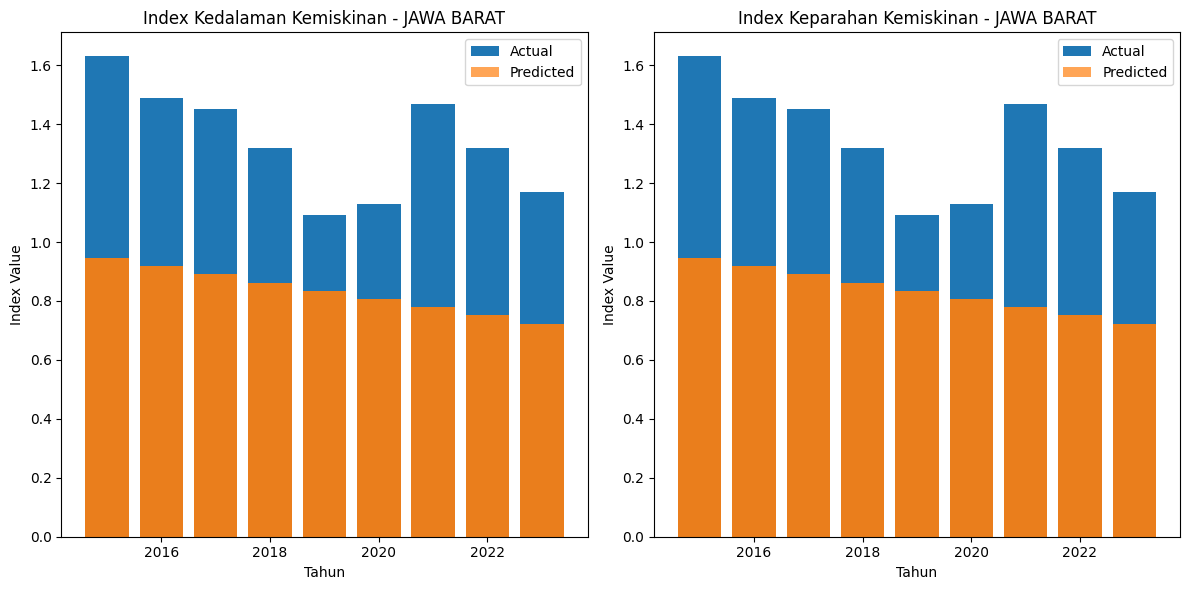

In [12]:
# Pastikan ada data untuk dilatih
if jumlah_baris_setelah_filtering > 0:
    # Gunakan VectorAssembler untuk menggabungkan kolom menjadi vektor fitur
    assembler = VectorAssembler(inputCols=["nama_tahun"], outputCol="features")
    df_assembled = assembler.transform(df_wilayah)

    # Linear Regression Model
    lr = LinearRegression(featuresCol="features", labelCol="data_content")
    model = lr.fit(df_assembled)

    # Predictions
    predictions = model.transform(df_assembled)

    # Ambil data untuk plotting
    actual_data = df_wilayah.select("nama_tahun", "data_content").toPandas()
    predicted_data = predictions.select("nama_tahun", "prediction").toPandas()

    # Plotting menggunakan bar chart
    plt.figure(figsize=(12, 6))

    # Grafik untuk Index Kedalaman Kemiskinan
    plt.subplot(1, 2, 1)
    plt.bar(actual_data["nama_tahun"], actual_data["data_content"], label="Actual")
    plt.bar(predicted_data["nama_tahun"], predicted_data["prediction"], label="Predicted", alpha=0.7)
    plt.title(f"Index Kedalaman Kemiskinan - {wilayah}")
    plt.xlabel("Tahun")
    plt.ylabel("Index Value")
    plt.legend()

    # Grafik untuk Index Keparahan Kemiskinan
    plt.subplot(1, 2, 2)
    plt.bar(actual_data["nama_tahun"], actual_data["data_content"], label="Actual")
    plt.bar(predicted_data["nama_tahun"], predicted_data["prediction"], label="Predicted", alpha=0.7)
    plt.title(f"Index Keparahan Kemiskinan - {wilayah}")
    plt.xlabel("Tahun")
    plt.ylabel("Index Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print(f"Tidak ada data yang cukup untuk melatih model untuk {wilayah}.")

In [13]:
# Evaluasi model
evaluation = model.evaluate(df_assembled)

# Ambil metrik evaluasi
rmse = evaluation.rootMeanSquaredError
r2 = evaluation.r2

# Tampilkan metrik evaluasi
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Root Mean Squared Error (RMSE): 0.5183885953853059
R-squared (R2): 0.01885649059581518


In [14]:
# Filter hanya provinsi (nama_wilayah huruf kapital) untuk Index Kedalaman Kemiskinan
df_provinsi_kedalaman = df.filter(
    (col("nama_wilayah").rlike("^[A-Z\s]+$")) &
    (col("nama_variabel") == "Index Kedalaman Kemiskinan")
)
# Show the filtered DataFrames
df_provinsi_kedalaman.show()

+--------------------+----------+-------------------+------------+
|       nama_variabel|nama_tahun|       nama_wilayah|data_content|
+--------------------+----------+-------------------+------------+
|Index Kedalaman K...|    2023.0|               ACEH|        2.76|
|Index Kedalaman K...|    2023.0|     SUMATERA UTARA|        1.26|
|Index Kedalaman K...|    2023.0|     SUMATERA BARAT|        0.82|
|Index Kedalaman K...|    2023.0|               RIAU|         1.0|
|Index Kedalaman K...|    2023.0|              JAMBI|         1.2|
|Index Kedalaman K...|    2023.0|   SUMATERA SELATAN|        1.72|
|Index Kedalaman K...|    2023.0|           BENGKULU|        2.14|
|Index Kedalaman K...|    2023.0|            LAMPUNG|        1.64|
|Index Kedalaman K...|    2023.0|     KEPULAUAN RIAU|        0.82|
|Index Kedalaman K...|    2023.0|        DKI JAKARTA|         0.7|
|Index Kedalaman K...|    2023.0|         JAWA BARAT|        1.17|
|Index Kedalaman K...|    2023.0|        JAWA TENGAH|        1

In [15]:
# Filter hanya provinsi (nama_wilayah huruf kapital) untuk Index Keparahan Kemiskinan
df_provinsi_keparahan = df.filter(
    (col("nama_wilayah").rlike("^[A-Z\s]+$")) &
    (col("nama_variabel") == "Index Keparahan Kemiskinan")
)
# Show the filtered DataFrames
df_provinsi_keparahan.show()

+--------------------+----------+-------------------+------------+
|       nama_variabel|nama_tahun|       nama_wilayah|data_content|
+--------------------+----------+-------------------+------------+
|Index Keparahan K...|    2023.0|               ACEH|        0.78|
|Index Keparahan K...|    2023.0|     SUMATERA UTARA|        0.32|
|Index Keparahan K...|    2023.0|     SUMATERA BARAT|        0.18|
|Index Keparahan K...|    2023.0|               RIAU|        0.24|
|Index Keparahan K...|    2023.0|              JAMBI|        0.29|
|Index Keparahan K...|    2023.0|   SUMATERA SELATAN|        0.39|
|Index Keparahan K...|    2023.0|           BENGKULU|        0.52|
|Index Keparahan K...|    2023.0|            LAMPUNG|        0.36|
|Index Keparahan K...|    2023.0|     KEPULAUAN RIAU|        0.18|
|Index Keparahan K...|    2023.0|        DKI JAKARTA|        0.18|
|Index Keparahan K...|    2023.0|         JAWA BARAT|        0.27|
|Index Keparahan K...|    2023.0|        JAWA TENGAH|        0

In [16]:
# Tampilkan jumlah baris setelah filtering
jml_baris_filter_prov_kedalaman = df_provinsi_kedalaman.count()
print(f"Jumlah baris setelah filtering untuk Index Kedalaman Kemiskinan berdasarkan Provinsi: {jml_baris_filter_prov_kedalaman}")

Jumlah baris setelah filtering untuk Index Kedalaman Kemiskinan berdasarkan Provinsi: 297


In [17]:
# Tampilkan jumlah baris setelah filtering
jml_baris_filter_prov_keparahan = df_provinsi_keparahan.count()
print(f"Jumlah baris setelah filtering untuk Index Kedalaman Kemiskinan berdasarkan Provinsi: {jml_baris_filter_prov_keparahan}")

Jumlah baris setelah filtering untuk Index Kedalaman Kemiskinan berdasarkan Provinsi: 297


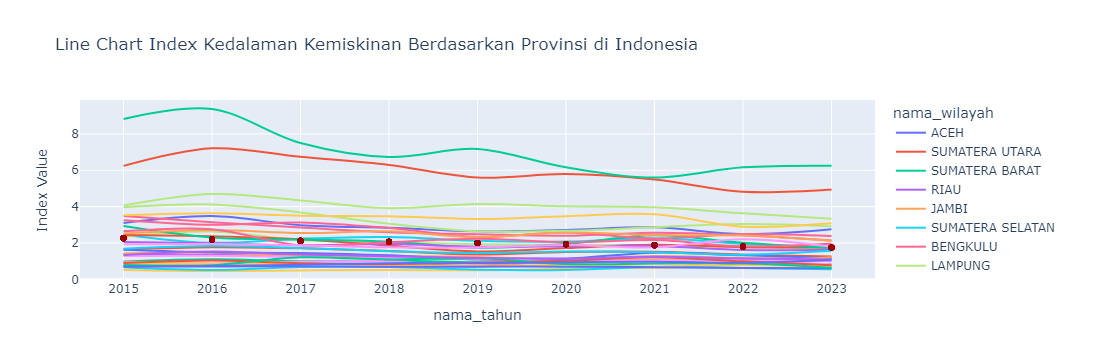

In [18]:
# Pastikan ada data untuk dilatih
jml_baris_filter_prov_kedalaman = df_provinsi_kedalaman.count()
if jml_baris_filter_prov_kedalaman > 0:
    # Gunakan VectorAssembler untuk menggabungkan kolom menjadi vektor fitur
    assembler = VectorAssembler(inputCols=["nama_tahun"], outputCol="features")
    df_assembled = assembler.transform(df_provinsi_kedalaman)

    # Linear Regression Model
    lr = LinearRegression(featuresCol="features", labelCol="data_content")
    model = lr.fit(df_assembled)

    # Predictions
    predictions = model.transform(df_assembled)

    # Ambil data untuk plotting
    actual_data = df_provinsi_kedalaman.select("nama_wilayah", "nama_tahun", "data_content").toPandas()
    predicted_data = predictions.select("nama_wilayah", "nama_tahun", "prediction").toPandas()

    # Membuat line chart menggunakan plotly
    fig = px.line(
        actual_data,
        x="nama_tahun",
        y="data_content",
        color="nama_wilayah",
        labels={"data_content": "Index Value"},
        title="Line Chart Index Kedalaman Kemiskinan Berdasarkan Provinsi di Indonesia",
        hover_data=["nama_wilayah", "nama_tahun"],
        line_shape='spline',  # Menambahkan garis tren dengan bentuk spline
    )

    # Menambahkan scatter plot untuk hasil prediksi
    fig.add_scatter(
        x=predicted_data["nama_tahun"],
        y=predicted_data["prediction"],
        mode="markers",
        name="Predicted",
        marker=dict(color="rgba(152, 0, 0, .8)"),
        text=predicted_data["nama_wilayah"],
        hoverinfo="text",
    )

    # Menampilkan plot
    fig.show()
    # Menyimpan plot sebagai file HTML
    fig.write_html("Line Chart Index Kedalaman Kemiskinan Berdasarkan Provinsi di Indonesia.html")
    # Menampilkan nama file HTML menggunakan web browser
    webbrowser.open("Line Chart Index Kedalaman Kemiskinan Berdasarkan Provinsi di Indonesia.html")
    

else:
    print("Tidak ada data yang cukup untuk melatih model untuk provinsi.")


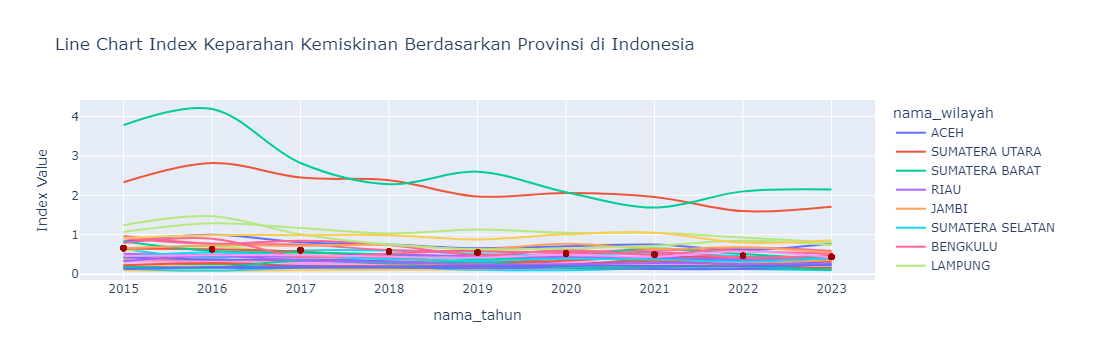

In [19]:
# Pastikan ada data untuk dilatih
jml_baris_filter_prov_keparahan = df_provinsi_keparahan.count()
if jml_baris_filter_prov_keparahan > 0:
    # Gunakan VectorAssembler untuk menggabungkan kolom menjadi vektor fitur
    assembler = VectorAssembler(inputCols=["nama_tahun"], outputCol="features")
    df_assembled = assembler.transform(df_provinsi_keparahan)

    # Linear Regression Model
    lr = LinearRegression(featuresCol="features", labelCol="data_content")
    model = lr.fit(df_assembled)

    # Predictions
    predictions = model.transform(df_assembled)

    # Ambil data untuk plotting
    actual_data = df_provinsi_keparahan.select("nama_wilayah", "nama_tahun", "data_content").toPandas()
    predicted_data = predictions.select("nama_wilayah", "nama_tahun", "prediction").toPandas()

    # Membuat line chart menggunakan plotly
    fig = px.line(
        actual_data,
        x="nama_tahun",
        y="data_content",
        color="nama_wilayah",
        labels={"data_content": "Index Value"},
        title="Line Chart Index Keparahan Kemiskinan Berdasarkan Provinsi di Indonesia",
        hover_data=["nama_wilayah", "nama_tahun"],
        line_shape='spline',  # Menambahkan garis tren dengan bentuk spline
    )

    # Menambahkan scatter plot untuk hasil prediksi
    fig.add_scatter(
        x=predicted_data["nama_tahun"],
        y=predicted_data["prediction"],
        mode="markers",
        name="Predicted",
        marker=dict(color="rgba(152, 0, 0, .8)"),
        text=predicted_data["nama_wilayah"],
        hoverinfo="text",
    )

    # Menampilkan plot
    fig.show()
    # Menyimpan plot sebagai file HTML
    fig.write_html("Line Chart Index Keparahan Kemiskinan Berdasarkan Provinsi di Indonesia.html")
    # Menampilkan nama file HTML menggunakan web browser
    webbrowser.open("Line Chart Index Keparahan Kemiskinan Berdasarkan Provinsi di Indonesia.html")

else:
    print("Tidak ada data yang cukup untuk melatih model untuk provinsi.")


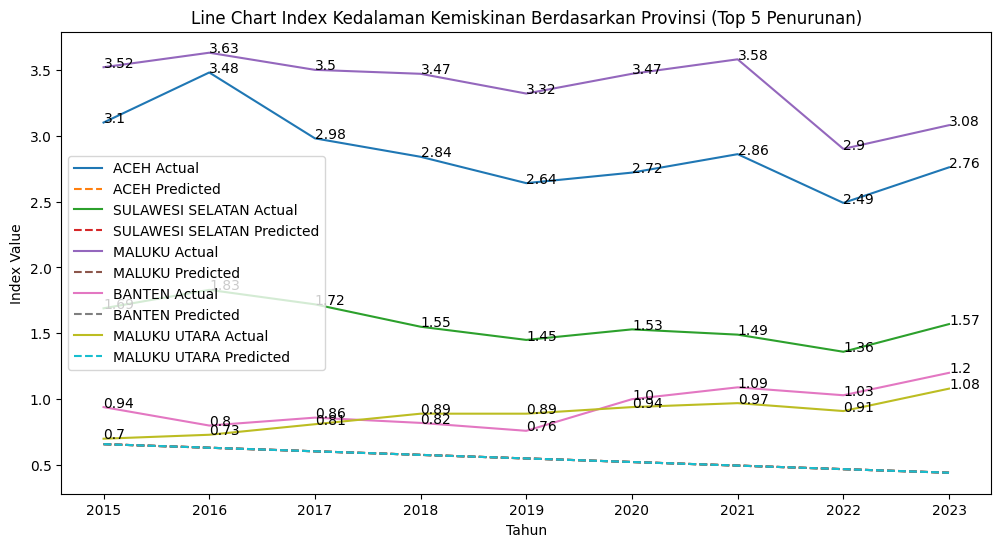

In [20]:
# Ambil data untuk plotting
actual_data = df_provinsi_kedalaman.select("nama_wilayah", "nama_tahun", "data_content").toPandas()
predicted_data = predictions.select("nama_wilayah", "nama_tahun", "prediction").toPandas()

# Gabungkan data aktual dan hasil prediksi
combined_data = pd.merge(actual_data, predicted_data, on=["nama_wilayah", "nama_tahun"], how="inner")

# Sortir data berdasarkan penurunan index kedalaman kemiskinan
combined_data = combined_data.sort_values(by=["nama_wilayah", "nama_tahun"])
combined_data["penurunan_index"] = combined_data.groupby("nama_wilayah")["data_content"].diff()

# Ambil 5 provinsi teratas dengan penurunan index paling signifikan
top_5_provinsi = combined_data.groupby("nama_wilayah").last().nlargest(5, "penurunan_index")

# Membuat line chart menggunakan matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

for provinsi in top_5_provinsi.index:
    provinsi_data = combined_data[combined_data["nama_wilayah"] == provinsi]
    ax.plot(provinsi_data["nama_tahun"], provinsi_data["data_content"], label=f"{provinsi} Actual")
    ax.plot(provinsi_data["nama_tahun"], provinsi_data["prediction"], linestyle="--", label=f"{provinsi} Predicted")
    
    # Menambahkan nilai data_content pada tiap titik
    for i, txt in enumerate(provinsi_data["data_content"]):
        ax.text(provinsi_data["nama_tahun"].iloc[i], provinsi_data["data_content"].iloc[i], round(txt, 2))

# Menambahkan label dan judul
ax.set_xlabel("Tahun")
ax.set_ylabel("Index Value")
ax.set_title("Line Chart Index Kedalaman Kemiskinan Berdasarkan Provinsi (Top 5 Penurunan)")

# Menambahkan legenda
ax.legend()

# Menampilkan plot
plt.show()

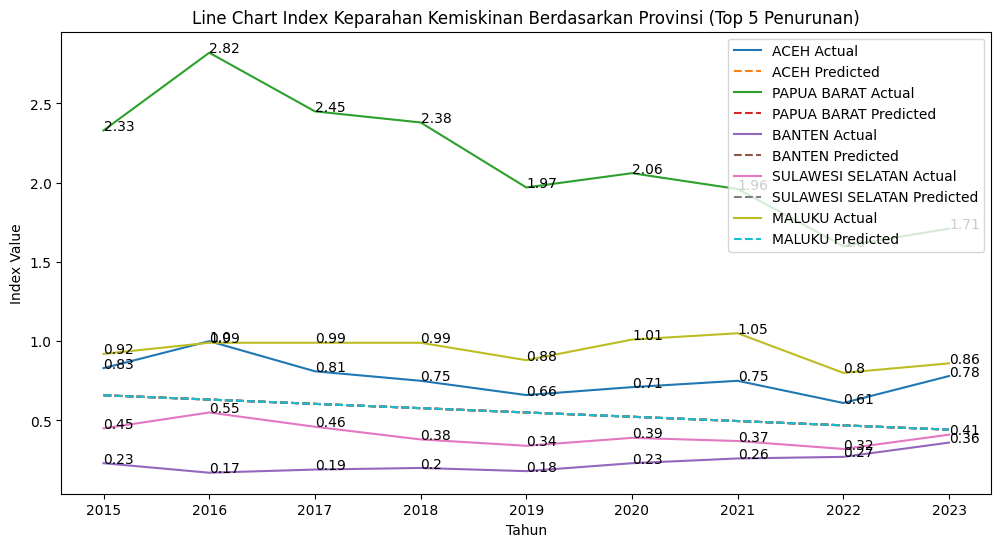

In [21]:
# Ambil data untuk plotting
actual_data = df_provinsi_keparahan.select("nama_wilayah", "nama_tahun", "data_content").toPandas()
predicted_data = predictions.select("nama_wilayah", "nama_tahun", "prediction").toPandas()

# Gabungkan data aktual dan hasil prediksi
combined_data = pd.merge(actual_data, predicted_data, on=["nama_wilayah", "nama_tahun"], how="inner")

# Sortir data berdasarkan penurunan index kedalaman kemiskinan
combined_data = combined_data.sort_values(by=["nama_wilayah", "nama_tahun"])
combined_data["penurunan_index"] = combined_data.groupby("nama_wilayah")["data_content"].diff()

# Ambil 5 provinsi teratas dengan penurunan index paling signifikan
top_5_provinsi = combined_data.groupby("nama_wilayah").last().nlargest(5, "penurunan_index")

# Membuat line chart menggunakan matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

for provinsi in top_5_provinsi.index:
    provinsi_data = combined_data[combined_data["nama_wilayah"] == provinsi]
    ax.plot(provinsi_data["nama_tahun"], provinsi_data["data_content"], label=f"{provinsi} Actual")
    ax.plot(provinsi_data["nama_tahun"], provinsi_data["prediction"], linestyle="--", label=f"{provinsi} Predicted")
    
    # Menambahkan nilai data_content pada tiap titik
    for i, txt in enumerate(provinsi_data["data_content"]):
        ax.text(provinsi_data["nama_tahun"].iloc[i], provinsi_data["data_content"].iloc[i], round(txt, 2))

# Menambahkan label dan judul
ax.set_xlabel("Tahun")
ax.set_ylabel("Index Value")
ax.set_title("Line Chart Index Keparahan Kemiskinan Berdasarkan Provinsi (Top 5 Penurunan)")

# Menambahkan legenda
ax.legend()

# Menampilkan plot
plt.show()

In [22]:
# Filter for Index Kedalaman Kemiskinan kabupaten/kota
df_kabupaten_kedalaman = df.filter(
    (col("nama_wilayah").rlike("^[A-Z][a-z\s]+$")) &
    (col("nama_variabel") == "Index Kedalaman Kemiskinan")
)

df_kabupaten_kedalaman.show()

+--------------------+----------+------------+------------+
|       nama_variabel|nama_tahun|nama_wilayah|data_content|
+--------------------+----------+------------+------------+
|Index Kedalaman K...|    2023.0|    Simeulue|        3.26|
|Index Kedalaman K...|    2023.0|       Pidie|        4.09|
|Index Kedalaman K...|    2023.0|     Bireuen|         1.9|
|Index Kedalaman K...|    2023.0|        Nias|        1.95|
|Index Kedalaman K...|    2023.0|      Asahan|        0.77|
|Index Kedalaman K...|    2023.0|  Simalungun|         1.0|
|Index Kedalaman K...|    2023.0|       Dairi|        0.93|
|Index Kedalaman K...|    2023.0|        Karo|        1.17|
|Index Kedalaman K...|    2023.0|     Langkat|        2.22|
|Index Kedalaman K...|    2023.0|     Samosir|        1.87|
|Index Kedalaman K...|    2023.0|       Solok|        0.93|
|Index Kedalaman K...|    2023.0|   Sijunjung|        0.85|
|Index Kedalaman K...|    2023.0|        Agam|        0.75|
|Index Kedalaman K...|    2023.0|     Pa

In [23]:
# Filter for Index Keparahan Kemiskinan kabupaten/kota
df_kabupaten_keparahan = df.filter(
    (col("nama_wilayah").rlike("^[A-Z][a-z\s]+$")) &
    (col("nama_variabel") == "Index Keparahan Kemiskinan")
)

df_kabupaten_keparahan.show()

+--------------------+----------+------------+------------+
|       nama_variabel|nama_tahun|nama_wilayah|data_content|
+--------------------+----------+------------+------------+
|Index Keparahan K...|    2023.0|    Simeulue|        0.96|
|Index Keparahan K...|    2023.0|       Pidie|        1.23|
|Index Keparahan K...|    2023.0|     Bireuen|        0.46|
|Index Keparahan K...|    2023.0|        Nias|         0.4|
|Index Keparahan K...|    2023.0|      Asahan|        0.13|
|Index Keparahan K...|    2023.0|  Simalungun|        0.21|
|Index Keparahan K...|    2023.0|       Dairi|        0.17|
|Index Keparahan K...|    2023.0|        Karo|        0.29|
|Index Keparahan K...|    2023.0|     Langkat|        0.79|
|Index Keparahan K...|    2023.0|     Samosir|         0.5|
|Index Keparahan K...|    2023.0|       Solok|        0.19|
|Index Keparahan K...|    2023.0|   Sijunjung|        0.21|
|Index Keparahan K...|    2023.0|        Agam|        0.13|
|Index Keparahan K...|    2023.0|     Pa

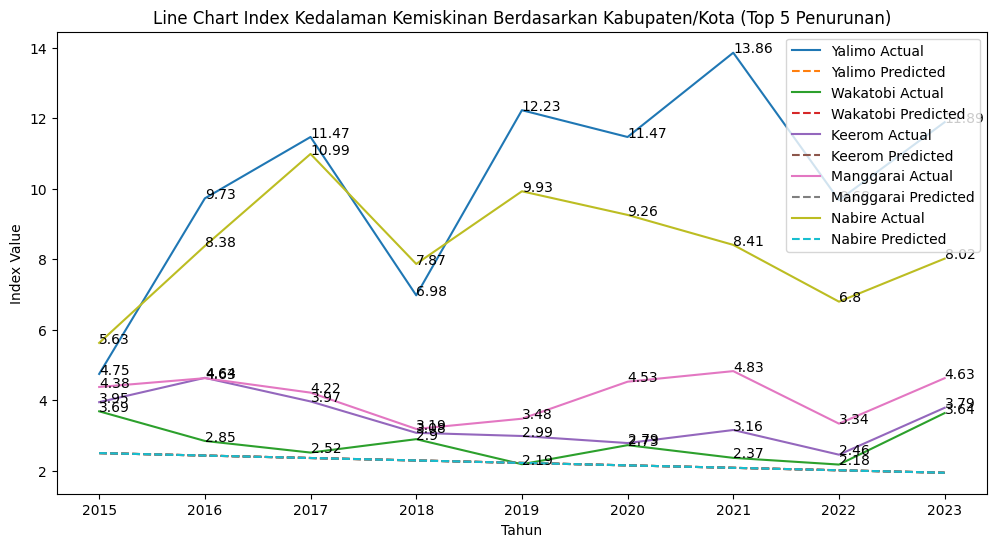

In [24]:
# Gunakan VectorAssembler untuk menggabungkan kolom menjadi vektor fitur
assembler_kedalaman = VectorAssembler(inputCols=["nama_tahun"], outputCol="features")
df_assembled_kedalaman = assembler_kedalaman.transform(df_kabupaten_kedalaman)

# Linear Regression Model
lr_kedalaman = LinearRegression(featuresCol="features", labelCol="data_content")
model_kedalaman = lr_kedalaman.fit(df_assembled_kedalaman)

# Predictions
predictions_kedalaman = model_kedalaman.transform(df_assembled_kedalaman)

# Ambil data untuk plotting dari df_kabupaten_kedalaman
actual_data_kedalaman = df_kabupaten_kedalaman.select("nama_wilayah", "nama_tahun", "data_content").toPandas()
predicted_data_kedalaman = predictions_kedalaman.select("nama_wilayah", "nama_tahun", "prediction").toPandas()

# Gabungkan data aktual dan hasil prediksi
combined_data_kedalaman = pd.merge(actual_data_kedalaman, predicted_data_kedalaman, on=["nama_wilayah", "nama_tahun"], how="inner")

# Sortir data berdasarkan penurunan index kedalaman kemiskinan
combined_data_kedalaman = combined_data_kedalaman.sort_values(by=["nama_wilayah", "nama_tahun"])
combined_data_kedalaman["penurunan_index"] = combined_data_kedalaman.groupby("nama_wilayah")["data_content"].diff()

# Ambil 5 wilayah teratas dengan penurunan index paling signifikan
top_5_kedalaman = combined_data_kedalaman.groupby("nama_wilayah").last().nlargest(5, "penurunan_index")

# Membuat line chart menggunakan matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

for wilayah in top_5_kedalaman.index:
    wilayah_data = combined_data_kedalaman[combined_data_kedalaman["nama_wilayah"] == wilayah]
    ax.plot(wilayah_data["nama_tahun"], wilayah_data["data_content"], label=f"{wilayah} Actual")
    ax.plot(wilayah_data["nama_tahun"], wilayah_data["prediction"], linestyle="--", label=f"{wilayah} Predicted")
    
    # Menambahkan nilai data_content pada tiap titik
    for i, txt in enumerate(wilayah_data["data_content"]):
        ax.text(wilayah_data["nama_tahun"].iloc[i], wilayah_data["data_content"].iloc[i], round(txt, 2))

# Menambahkan label dan judul
ax.set_xlabel("Tahun")
ax.set_ylabel("Index Value")
ax.set_title("Line Chart Index Kedalaman Kemiskinan Berdasarkan Kabupaten/Kota (Top 5 Penurunan)")

# Menambahkan legenda
ax.legend()

# Menampilkan plot
plt.show()

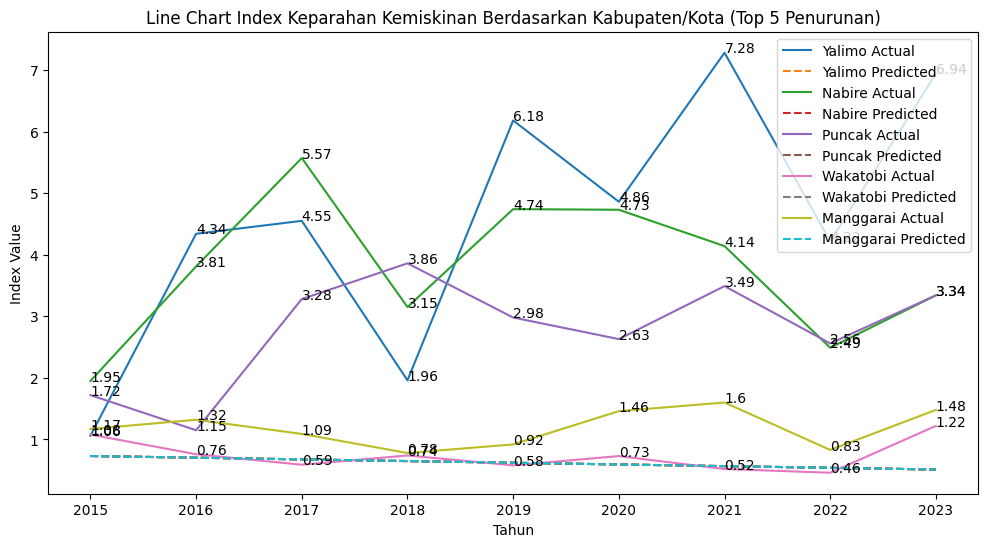

In [25]:
# Gunakan VectorAssembler untuk menggabungkan kolom menjadi vektor fitur
assembler_keparahan = VectorAssembler(inputCols=["nama_tahun"], outputCol="features")
df_assembled_keparahan = assembler_keparahan.transform(df_kabupaten_keparahan)

# Linear Regression Model
lr_keparahan = LinearRegression(featuresCol="features", labelCol="data_content")
model_keparahan = lr_keparahan.fit(df_assembled_keparahan)

# Predictions
predictions_keparahan = model_keparahan.transform(df_assembled_keparahan)

# Ambil data untuk plotting dari df_kabupaten_keparahan
actual_data_keparahan = df_kabupaten_keparahan.select("nama_wilayah", "nama_tahun", "data_content").toPandas()
predicted_data_keparahan = predictions_keparahan.select("nama_wilayah", "nama_tahun", "prediction").toPandas()

# Gabungkan data aktual dan hasil prediksi
combined_data_keparahan = pd.merge(actual_data_keparahan, predicted_data_keparahan, on=["nama_wilayah", "nama_tahun"], how="inner")

# Sortir data berdasarkan penurunan index keparahan kemiskinan
combined_data_keparahan = combined_data_keparahan.sort_values(by=["nama_wilayah", "nama_tahun"])
combined_data_keparahan["penurunan_index"] = combined_data_keparahan.groupby("nama_wilayah")["data_content"].diff()

# Ambil 5 wilayah teratas dengan penurunan index paling signifikan
top_5_keparahan = combined_data_keparahan.groupby("nama_wilayah").last().nlargest(5, "penurunan_index")

# Membuat line chart menggunakan matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

for wilayah in top_5_keparahan.index:
    wilayah_data = combined_data_keparahan[combined_data_keparahan["nama_wilayah"] == wilayah]
    ax.plot(wilayah_data["nama_tahun"], wilayah_data["data_content"], label=f"{wilayah} Actual")
    ax.plot(wilayah_data["nama_tahun"], wilayah_data["prediction"], linestyle="--", label=f"{wilayah} Predicted")
    
    # Menambahkan nilai data_content pada tiap titik
    for i, txt in enumerate(wilayah_data["data_content"]):
        ax.text(wilayah_data["nama_tahun"].iloc[i], wilayah_data["data_content"].iloc[i], round(txt, 2))

# Menambahkan label dan judul
ax.set_xlabel("Tahun")
ax.set_ylabel("Index Value")
ax.set_title("Line Chart Index Keparahan Kemiskinan Berdasarkan Kabupaten/Kota (Top 5 Penurunan)")

# Menambahkan legenda
ax.legend()

# Menampilkan plot
plt.show()